# Time Series Forecasting

One of the goals of time series analysis is forecasting. Forecasting can be done when the response variable is a time series and we use earlier values of the time series as inputs to the forecast. Examples are autoregression or naive forecasting. 

We can also forecast using other variables as inputs to the forcast model. Finally, we can combine both approachs to use both past values of the response variable and other variables as inputs to the forecast model.


In [1]:
%matplotlib inline

# # Printing
import locale


# # Data
import pandas as pd
import numpy as np
import scipy as sp
import statsmodels.api as sm

# # Time series

from datetime import datetime
from datetime import timedelta
from dateutil.parser import parse
from statsmodels.tsa.arima_model import ARIMA

# # Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import savefig

# sns.set(style="darkgrid", color_codes=True)






/Users/mead/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Example - Airline Passenger Data

Get the airline passenger data from the url below and read it into a data frame. Look at its shape.

https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

In [2]:
path = "/Users/mead/Fall2017/DonBrown-DS6001/TimeSeries/"
file = "international-airline-passengers.csv"
airlines = pd.read_csv(path+file,  header = 0, names = ['Date', 'Passengers'])
airlines.shape

(145, 2)

In [3]:
# Remove null value

airlines.drop(144, inplace = True)

In [4]:
# Making column Date into a datetime index.

airlines['Date'] = pd.to_datetime(airlines['Date'], format = "%Y-%m")

airlines.index = airlines['Date']
airlines.drop('Date', axis = 1, inplace = True)
airlines.head()

,Passengers
Date,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


## Exponential moving average

$\hat{X}_{t+1} = \alpha X_t + (1-\alpha)\hat{X}_{t}$, where

  $X_t$ is the time series at time $t = 1, 2, \ldots, N$
  
  $\hat{X}_{t+i}$ is the forecast of the time series at time $i = 1, 2, \ldots$
  
  $\alpha$ is the weight on the current time, so the larger $\alpha$ the more we discount the past. In pandas,
  
  $\alpha = \frac{2}{\textrm{Span} +1}$

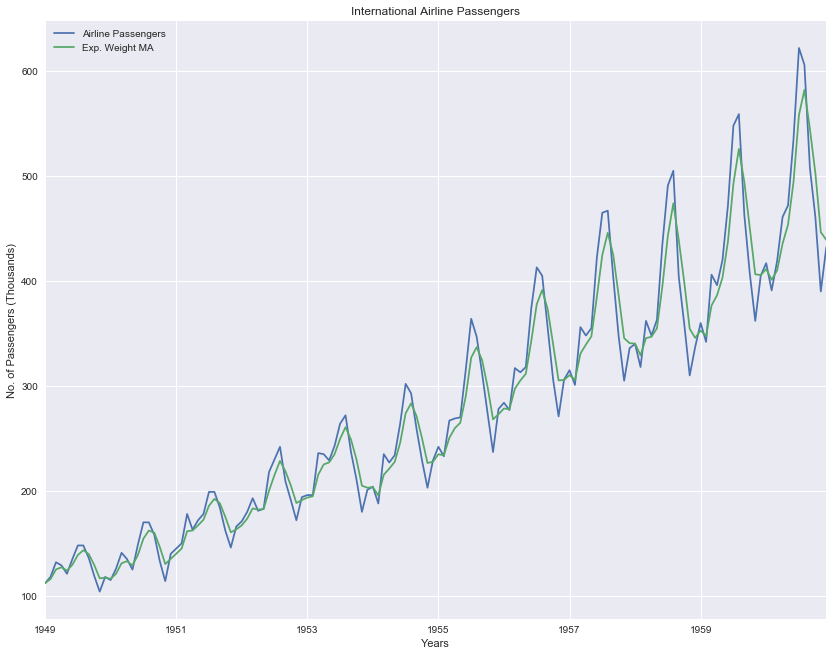

In [5]:
# Exponential Smoothing

import matplotlib.dates as mdates

fig = plt.figure(figsize = (14,11))
ts = fig.add_subplot(1, 1, 1)
airlines.Passengers.plot(label = 'Airline Passengers')
airlines.Passengers.ewm(span=3).mean().plot(label = 'Exp. Weight MA')
ts.legend(loc = 'best')
ts.set_title("International Airline Passengers")
ts.set_ylabel("No. of Passengers (Thousands)")
ts.set_xlabel("Years")



In [6]:
# Predict

ewma_forecast = airlines.Passengers.ewm(span=3).mean()['1960-12-01']*.5 + airlines.Passengers['1960-12-01']*.5

print('Exponential Smoothing forecast for January 1, 1961: %.0f' % ewma_forecast)

Exponential Smoothing forecast for January 1, 1961: 436


## ARMA Models

An approach to time domain modeling suggested by Box and Jenkins (1976) that can be used for forecasting. The approach predicts future values using the past values of the time series. The process starts by looking at the autocorrelation function and the partial autocorrelation functions of the time series. The plots give insights into the order of the model.

There are several types of models. The two most base models are autoregressive and moving average. Autoregessive models use regression models where the response is the value of the time series at time $t+1$ and the predictors are all previous values of the time series. Here an autoregressive 2 variable, AR(2), model:

$X_t = \phi_0 + \phi_1 X_{t-1} + \phi_2 X_{t-2} + w_t$

A moving average model predicts the value of the time series at $t+1$ with current and previous values of the error or residual terms. Here is a moving average 2 variable MA(2) model:

$X_t = w_t - \theta_1 w_{t-1} - \theta_2 w_{t-2} $

Both of these basic forms can be combined to form ARMA models. Here is an ARMA(2,2) model:


$X_t = \phi_0 + \phi_1 X_{t-1} + \phi_2 X_{t-2}  - \theta_1 w_{t-1} - \theta_2 w_{t-2} + w_t $

Frequently,  differencing filters are used to achieve stationarity. This produces ARIMA models. We can also have seasonally adjusted ARIMA models or SARIMA and the can have autoregressive, moving average differencing operators for the seasonality.


In [7]:
# Dickey-Fuller test of stationarity
# 

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    # Null hypothesis is that the data are non-stationary
    print ('Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput) 

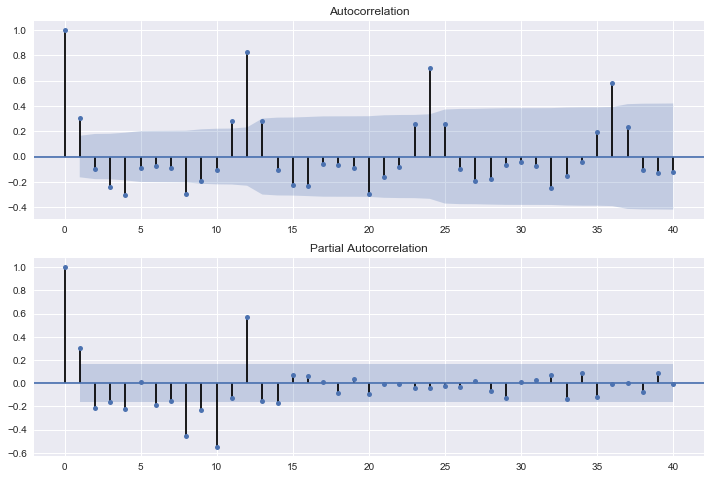

In [8]:
# Model 1
# First difference

PassengersDiff1 = airlines['Passengers'].diff(1)

# Look at ACF, PACF

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(PassengersDiff1.dropna(inplace = False), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(PassengersDiff1.dropna(inplace = False), lags=40, ax=ax2)

In [9]:

mod1 = ARIMA(airlines['Passengers'], order=(2, 1, 2))  
results = mod1.fit()
print (results.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -666.022
Method:                       css-mle   S.D. of innovations             24.712
Date:                Mon, 20 Nov 2017   AIC                           1344.043
Time:                        10:10:15   BIC                           1361.820
Sample:                    02-01-1949   HQIC                          1351.267
                         - 12-01-1960                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.5311      0.708      3.574      0.000       1.143       3.919
ar.L1.D.Passengers     1.6477      0.033     49.933      0.000       1.583       1.712
ar.L2.D.Passengers  

In [10]:
# Get the forecast

mod1_fitted = mod1.fit(disp=-1)  

forecast_mod1 = mod1_fitted.fittedvalues + airlines.Passengers.mean() \
#+ airlines.Passengers.shift(1).dropna(inplace = False)


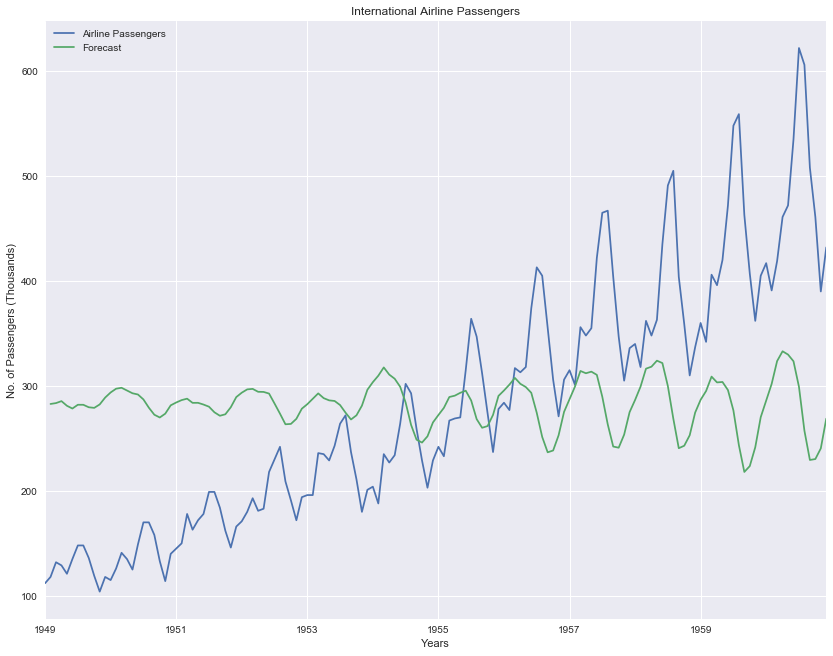

In [11]:
# Forecast

fig = plt.figure(figsize = (14,11))
ts = fig.add_subplot(1, 1, 1)
airlines.Passengers.plot(label = 'Airline Passengers')
forecast_mod1.plot(label = 'Forecast')

ts.legend(loc = 'best')
ts.set_title("International Airline Passengers")
ts.set_ylabel("No. of Passengers (Thousands)")
ts.set_xlabel("Years")


In [12]:
# Seasonal difference
# Model 2

PassengersDiff12 = airlines['Passengers'].diff(12)

#PassengersDiff12 = airlines['Passengers'] - airlines['Passengers'].shift(12)
test_stationarity(PassengersDiff12.dropna(inplace = False))


Dickey-Fuller Test:
Test Statistic                  -3.383021
p-value                          0.011551
#Lags Used                       1.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


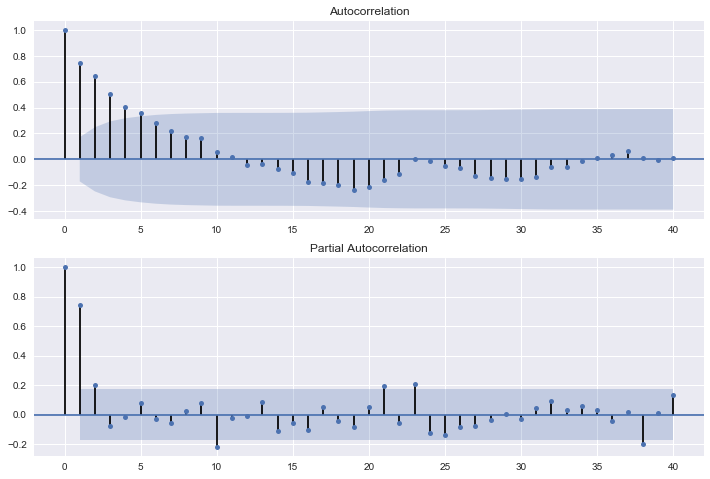

In [13]:
# Look at ACF, PACF

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(PassengersDiff12.dropna(inplace = False), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(PassengersDiff12.dropna(inplace = False), lags=40, ax=ax2)

In [14]:
#  model 2

from statsmodels.tsa.arima_model import ARIMA

mod2 = ARIMA(PassengersDiff12.dropna(inplace = False), order=(2, 1, 0))  
results = mod2.fit()
print (results.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.Passengers   No. Observations:                  131
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -508.171
Method:                       css-mle   S.D. of innovations             11.703
Date:                Mon, 20 Nov 2017   AIC                           1024.343
Time:                        10:10:23   BIC                           1035.844
Sample:                    02-01-1950   HQIC                          1029.016
                         - 12-01-1960                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1768      0.782      0.226      0.821      -1.356       1.710
ar.L1.D.Passengers    -0.3083      0.087     -3.532      0.001      -0.479      -0.137
ar.L2.D.Passengers  

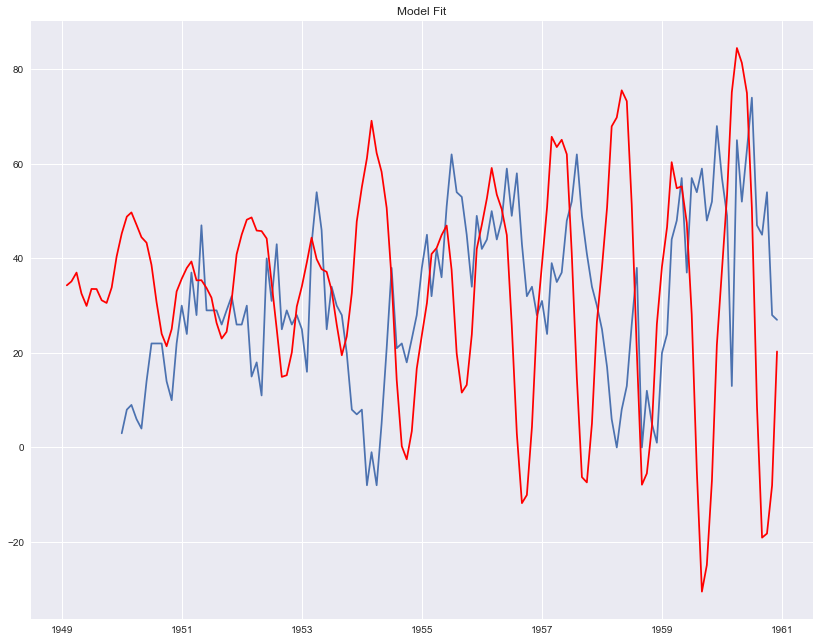

In [15]:
# The model fit
# plotted 

plt.figure(figsize = (14,11))
fit_AR = mod1.fit(disp=-1)  
plt.plot(PassengersDiff12.dropna(inplace = False))
plt.plot(fit_AR.fittedvalues + PassengersDiff12.dropna(inplace = False).mean(), color='red')
plt.title('Model Fit')

In [16]:
# Get the forecast


forecast = airlines.Passengers.shift(12).dropna(inplace = False) +fit_AR.fittedvalues\
+ PassengersDiff12.dropna(inplace = False).mean()



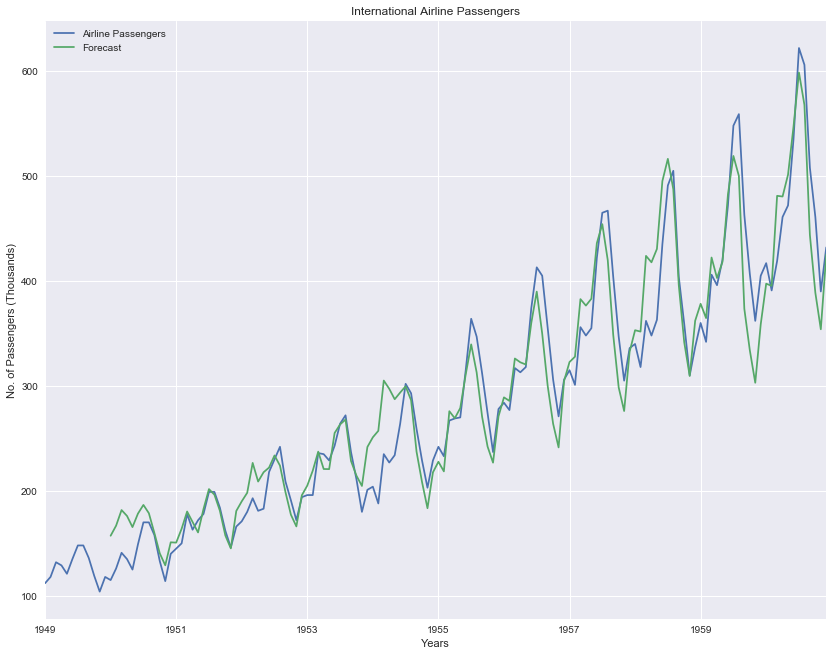

In [17]:
# Forecast

fig = plt.figure(figsize = (14,11))
ts = fig.add_subplot(1, 1, 1)
airlines.Passengers.plot(label = 'Airline Passengers')
forecast.plot(label = 'Forecast')

ts.legend(loc = 'best')
ts.set_title("International Airline Passengers")
ts.set_ylabel("No. of Passengers (Thousands)")
ts.set_xlabel("Years")


In [18]:
# forecast

ARIMA_seasonal = fit_AR.forecast()[0] + PassengersDiff12.dropna(inplace = False).mean()

print('ARMA prediction for January 1, 1961: %.0f' % ARIMA_seasonal)

ARMA prediction for January 1, 1961: 465


In [19]:
# Confidence interval


inverse_func = PassengersDiff12.dropna(inplace = False).mean()

intervals = [0.2, 0.1, 0.05, 0.01]
for a in intervals:
    forecast, stderr, conf = fit_AR.forecast(alpha=a)
    print('%.1f%% Confidence Interval: %.0f between %.0f and %.0f' %
          ((1-a)*100, forecast+inverse_func, conf[0][0]+inverse_func, conf[0][1]+inverse_func))



80.0% Confidence Interval: 465 between 433 and 497
90.0% Confidence Interval: 465 between 424 and 506
95.0% Confidence Interval: 465 between 416 and 513
99.0% Confidence Interval: 465 between 401 and 529


## Forecasting with other variables

Frequently we want to build models with multiple time dependent variables. To do this we build on ideas from ordinary least squares. See also transfer function models and state space models.



In [20]:
# Normalized mean squared error
# Compares models to the performance of the average

def norm_mse(pred_var, actual_var):
    '''
    Produces the rato of the predicted mse
    to the mse of the average
    '''
    ave_values = np.repeat(np.mean(actual_var), len(actual_var))
    denom = mean_squared_error(ave_values, actual_var)
    return mean_squared_error(pred_var, actual_var)/denom

In [22]:
path = '/Users/mead/Fall2017/DonBrown-DS6001/TimeSeries/'
file = 'Smog.csv'

smog_df = pd.read_csv(path+file)

smog_df.shape

(102, 5)

In [23]:

# Date index

smog_df.index = pd.date_range(start = '1951-01-01', periods = 102)
smog_df.index

DatetimeIndex(['1951-01-01', '1951-01-02', '1951-01-03', '1951-01-04',
               '1951-01-05', '1951-01-06', '1951-01-07', '1951-01-08',
               '1951-01-09', '1951-01-10',
               ...
               '1951-04-03', '1951-04-04', '1951-04-05', '1951-04-06',
               '1951-04-07', '1951-04-08', '1951-04-09', '1951-04-10',
               '1951-04-11', '1951-04-12'],
              dtype='datetime64[ns]', length=102, freq='D')

In [24]:
smog_df.head()

,Adj.Mortality,Brit.Smoke,SO2,Temp,Relative Humidity
1951-01-01,-26.2,297,220,6.4,80
1951-01-02,-32.6,263,172,5.0,81
1951-01-03,-23.0,291,227,5.0,82
1951-01-04,40.6,466,329,10.0,83
1951-01-05,12.2,730,478,6.2,89


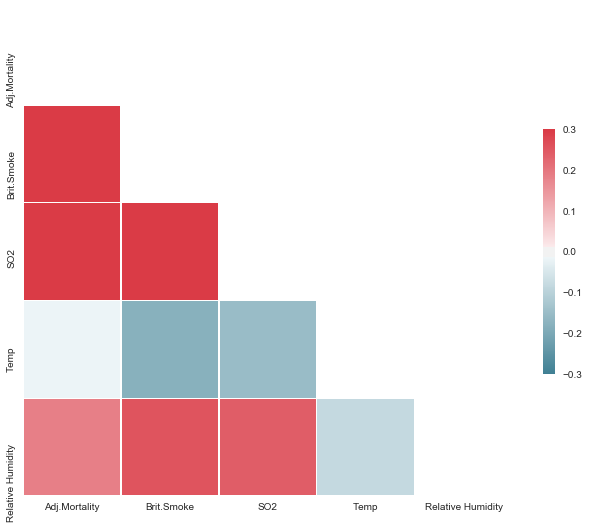

In [25]:
# Heat map to show correlations

sns.set(style="white")

# # Compute the correlation matrix
corr = smog_df.corr()

# # Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# # Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# # Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([ 0.05468935,  0.01753016, -0.00879311, -0.10690223, -0.19491774,
        -0.18823483, -0.14009293, -0.08354461, -0.01061111,  0.12943775,
         0.26322253,  0.12534197,  0.11460054,  0.08142871,  0.04714178,
        -0.0171692 , -0.04066519,  0.00700184,  0.00303718, -0.06942744,
        -0.0299443 ]),
 <matplotlib.lines.Line2D at 0x1155eec90>)

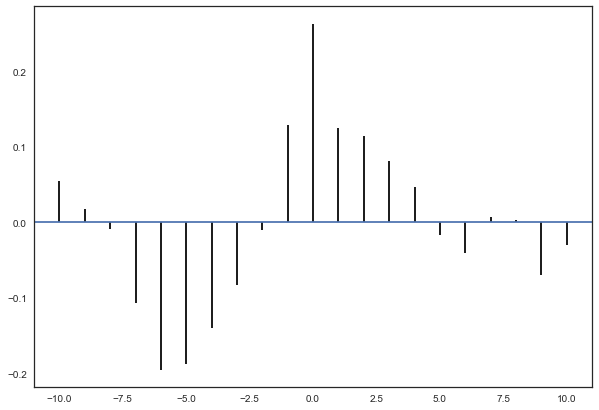

In [26]:
# Cross Correlation 
# Smoke and mortality

plt.figure(figsize = (10,7))
plt.xcorr(smog_df['Adj.Mortality'],smog_df['Brit.Smoke'])

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([ 0.01634316,  0.047505  ,  0.06261885,  0.05592145,  0.05587675,
         0.11622698,  0.12429897,  0.11627497,  0.04007922,  0.00494154,
        -0.02156736, -0.10131297, -0.14751373, -0.0973299 , -0.12329777,
        -0.09388456, -0.12064919, -0.05925438, -0.13300532, -0.16348415,
        -0.1137973 ]),
 <matplotlib.lines.Line2D at 0x1150d4710>)

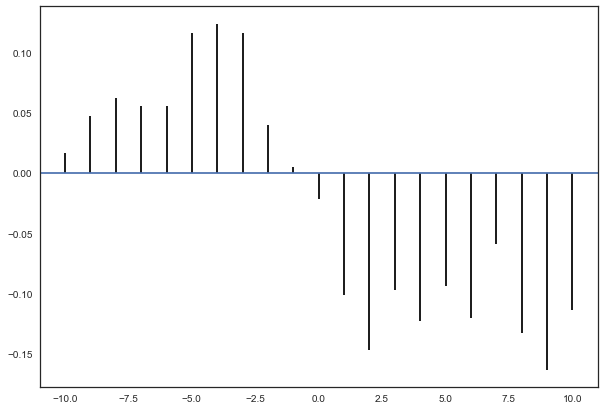

In [27]:
# Cross Correlation 
# Temp and mortality

plt.figure(figsize = (10,7))
plt.xcorr(smog_df['Adj.Mortality'],smog_df['Temp'])

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([  5.54920597e-03,  -9.43170182e-05,   2.01568309e-02,
         -4.68795433e-03,  -1.62552945e-03,  -8.38270175e-03,
         -6.83909083e-03,  -1.78493850e-02,  -1.68969160e-02,
          9.91878502e-03,  -6.54462690e-04,   2.92471317e-03,
          1.36104328e-02,   5.97252555e-03,  -2.94463930e-03,
         -1.77807505e-02,  -2.14684131e-02,  -4.55112823e-02,
         -4.63291393e-02,  -6.47249431e-02,  -6.03248106e-02]),
 <matplotlib.lines.Line2D at 0x115604bd0>)

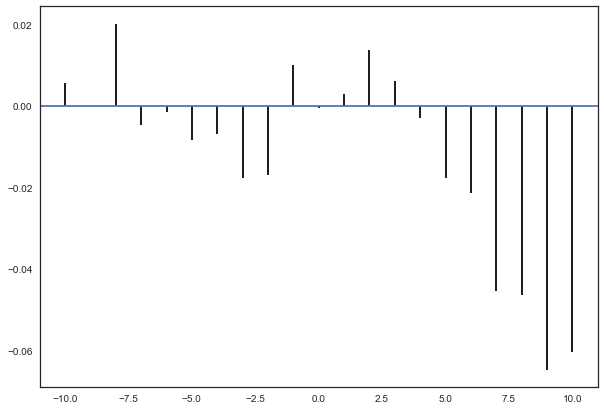

In [28]:
# Cross Correlation 
# Humidty and mortality

plt.figure(figsize = (10,7))
plt.xcorr(smog_df['Adj.Mortality'],smog_df['Relative Humidity'])

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([-0.00382557, -0.00285136,  0.05163583, -0.09269705, -0.1278125 ,
        -0.13158496, -0.09641839, -0.07007873,  0.01412992,  0.14952703,
         0.23556721,  0.08876804,  0.09263672,  0.06861901,  0.03797722,
        -0.01718621, -0.02413485, -0.00806658, -0.03644942, -0.09664518,
        -0.06525589]),
 <matplotlib.lines.Line2D at 0x11ad981d0>)

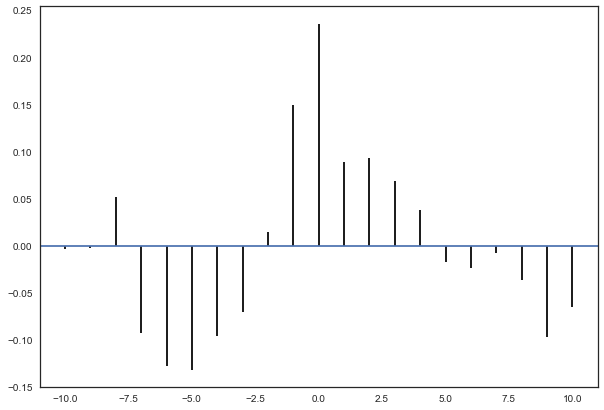

In [29]:
# Cross Correlation 
# Smoke and mortality

plt.figure(figsize = (10,7))
plt.xcorr(smog_df['Adj.Mortality'],smog_df['SO2'])

In [30]:
# Creating test and training sets

X_train = smog_df.loc[:'1951-04-03',"Brit.Smoke":'Relative Humidity']
X_test = smog_df.loc['1951-04-04':, "Brit.Smoke":'Relative Humidity']
y_train = smog_df.loc[:'1951-04-03','Adj.Mortality']
y_test = smog_df.loc['1951-04-04':,'Adj.Mortality']

In [31]:
X_train.shape

(93, 4)

In [32]:
# OLS model - main effects


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model

lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

y_fit = lr.predict(X_train)

y_pred = lr.predict(X_test)

#Performance on the test set

mse = mean_squared_error(y_pred, y_test)

nmse = norm_mse(y_pred, y_test)

print("Mean Square Error: %0.2f" % (mse))

print("Normalized Mean Square Error: %0.2f" % (nmse))


Mean Square Error: 687.16
Normalized Mean Square Error: 1.01


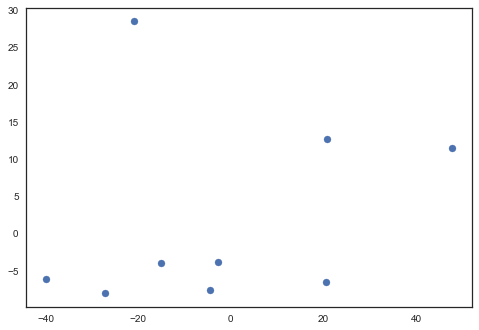

In [33]:
plt.scatter(y_test, y_pred)

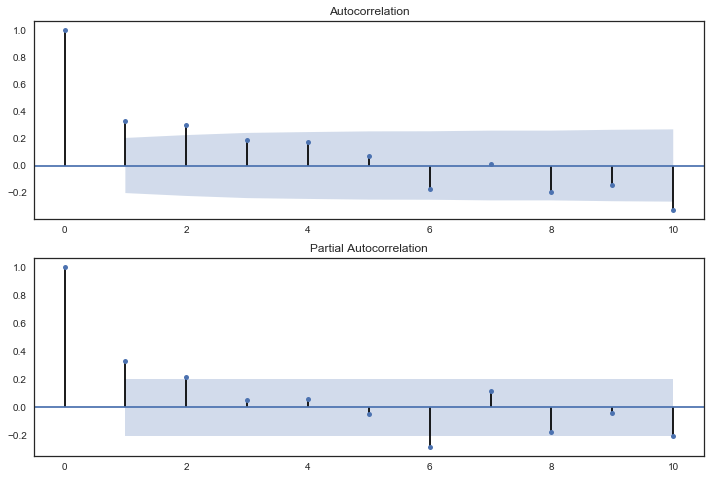

In [34]:
# Look at ACF, PACF

resid = y_train - y_fit

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid, lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=10, ax=ax2)

In [35]:
# # Adding the lagged temp variable

smog_Tshift2_df = smog_df.drop('Temp', axis = 1)

smog_Tshift2_df['Temp'] = smog_df['Temp'].shift(2)

smog_Tshift2_df.dropna(axis = 0, inplace = True)

smog_Tshift2_df.index

X_train = smog_Tshift2_df.loc[:'1951-04-03',["Brit.Smoke",'Temp']]
X_test = smog_Tshift2_df.loc['1951-04-04':, ["Brit.Smoke",'Temp']]
y_train = smog_Tshift2_df.loc[:'1951-04-03','Adj.Mortality']
y_test = smog_Tshift2_df.loc['1951-04-04':,'Adj.Mortality'] 


In [36]:
# OLS model - temp leading by 2 days


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model

lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

y_fit = lr.predict(X_train)

y_pred = lr.predict(X_test)

#Performance on the test set

mse = mean_squared_error(y_pred, y_test)

nmse = norm_mse(y_pred, y_test)

print("Mean Square Error: %0.2f" % (mse))

print("Normalized Mean Square Error: %0.2f" % (nmse))


Mean Square Error: 606.65
Normalized Mean Square Error: 0.90


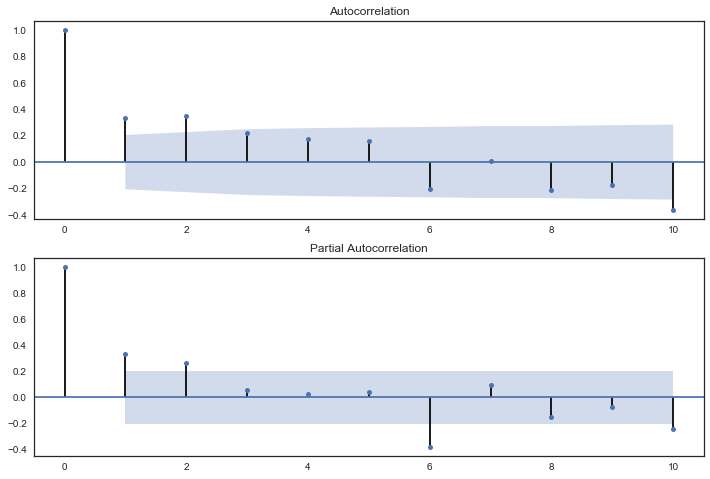

In [37]:
# # Look at ACF, PACF

resid = y_train - y_fit

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid, lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=10, ax=ax2)

In [38]:
#  ARIMA model of the residuals

resid_arima = ARIMA(resid, order=(1, 0, 0))  
results = resid_arima.fit()
print (results.summary())

                              ARMA Model Results                              
Dep. Variable:          Adj.Mortality   No. Observations:                   91
Model:                     ARMA(1, 0)   Log Likelihood                -398.431
Method:                       css-mle   S.D. of innovations             19.274
Date:                Mon, 20 Nov 2017   AIC                            802.862
Time:                        10:15:08   BIC                            810.394
Sample:                    01-03-1951   HQIC                           805.901
                         - 04-03-1951                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0037      3.015     -0.001      0.999      -5.913       5.905
ar.L1.Adj.Mortality     0.3335      0.098      3.388      0.001       0.141       0.526
                

In [39]:
arima_pred = y_pred + results.predict(start='1951-04-04', end='1951-04-12')

nmse = norm_mse(arima_pred, y_test)

print("Normalized Mean Square Error: %0.2f" % (nmse))

Normalized Mean Square Error: 0.87


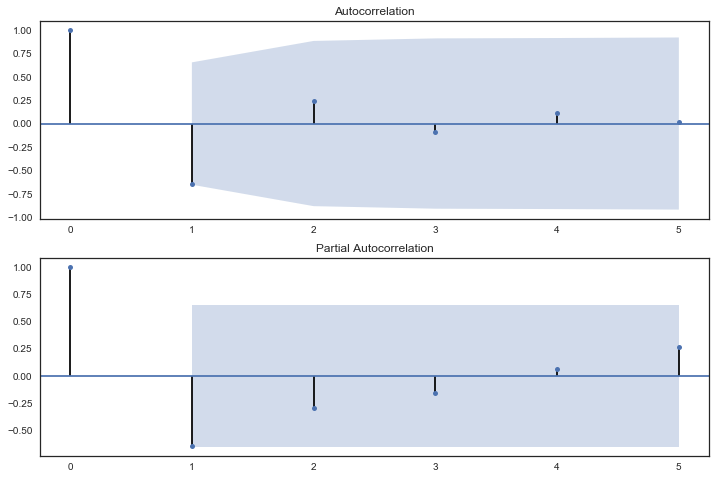

In [40]:
# # ACF, PACF of predicted residuals

resid_arima = y_test- arima_pred

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid_arima, lags=5, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid_arima, lags=5, ax=ax2)

In [41]:
# # # Adding the lagged mortality

smog_Mshift1_df = smog_df.drop('Temp', axis = 1)

smog_Mshift1_df['Temp'] = smog_df['Temp'].shift(2)

smog_Mshift1_df['AdjMort1'] = smog_df['Adj.Mortality'].shift(1)

smog_Mshift1_df['AdjMort2'] = smog_df['Adj.Mortality'].shift(2)

smog_Mshift1_df.dropna(axis = 0, inplace = True)


X_train = smog_Mshift1_df.loc[:'1951-04-03',["Brit.Smoke",'Temp','AdjMort1','AdjMort2']]
X_test = smog_Mshift1_df.loc['1951-04-04':, ["Brit.Smoke",'Temp','AdjMort1','AdjMort2']]
y_train = smog_Mshift1_df.loc[:'1951-04-03','Adj.Mortality']
y_test = smog_Mshift1_df.loc['1951-04-04':,'Adj.Mortality'] 

smog_Mshift1_df.shape


(100, 7)

In [42]:
# Naive forecast

X_train = smog_Mshift1_df.loc[:'1951-04-03',['AdjMort1']]
X_test = smog_Mshift1_df.loc['1951-04-04':, ['AdjMort1']]
y_train = smog_Mshift1_df.loc[:'1951-04-03','Adj.Mortality']
y_test = smog_Mshift1_df.loc['1951-04-04':,'Adj.Mortality']

In [43]:
# OLS model - temp leading by 2 days


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model

lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

y_fit = lr.predict(X_train)

y_pred = lr.predict(X_test)

#Performance on the test set

mse = mean_squared_error(y_pred, y_test)

nmse = norm_mse(y_pred, y_test)

print("Mean Square Error: %0.2f" % (mse))

print("Normalized Mean Square Error: %0.2f" % (nmse))


Mean Square Error: 992.21
Normalized Mean Square Error: 1.47


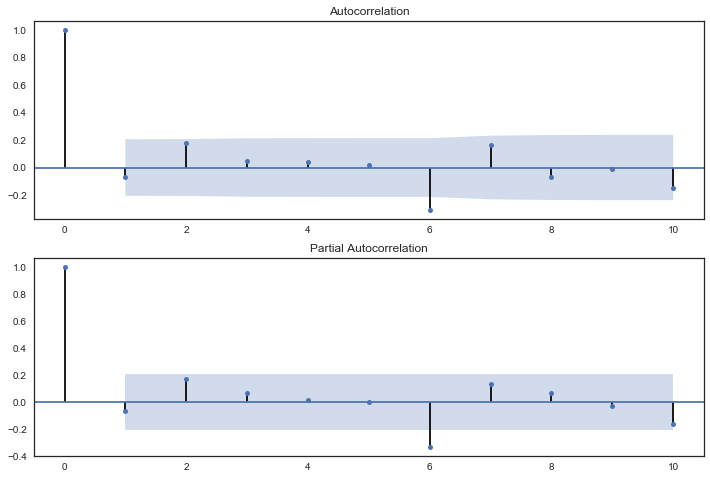

In [44]:
# # Look at ACF, PACF

resid = y_train - y_fit

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid, lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=10, ax=ax2)

## Exercise

Use the Bike-Sharing-Dataset to build at least one predictive model for cnt: count of total rental bikes including both casual and registered. Use the last month in the data set as a test set and use Normalized Mean Square Error to evaluate your model. 

To illustrate the approach we will use data from the first reported incident of smog: the Great Smog in London in 1952. The data set is Smog.csv.

USE ORDINARY LEAST SQUARES FOR AT LEAST ONE OF THE MODELS

# Extra

In [42]:

mod2 = ARIMA(airlines['Passengers'], order=(2, 1, 2))  
results = mod2.fit()
print (results.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -666.022
Method:                       css-mle   S.D. of innovations             24.714
Date:                Tue, 14 Nov 2017   AIC                           1344.043
Time:                        16:24:44   BIC                           1361.820
Sample:                    02-01-1949   HQIC                          1351.267
                         - 12-01-1960                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.5314      0.708      3.574      0.000       1.143       3.920
ar.L1.D.Passengers     1.6477      0.033     49.934      0.000       1.583       1.712
ar.L2.D.Passengers  

In [ ]:
# Get the forecast

mod2_fitted = mod2.fit(disp=-1)  

forecast_mod2 = mod2_fitted.fittedvalues + airlines.Passengers.mean() \
#+ airlines.Passengers.shift(1).dropna(inplace = False)


In [ ]:
# Forecast

fig = plt.figure(figsize = (14,11))
ts = fig.add_subplot(1, 1, 1)
airlines.Passengers.plot(label = 'Airline Passengers')
forecast_mod2.plot(label = 'Forecast')

ts.legend(loc = 'best')
ts.set_title("International Airline Passengers")
ts.set_ylabel("No. of Passengers (Thousands)")
ts.set_xlabel("Years")


In [ ]:
# forecast

ARIMA_seasonal = airlines.Passengers.shift(12).dropna(inplace = False)['1960-12-01'] +fit_AR.predict(start='1961-01-01', end='1961-01-01')\
+ PassengersDiff12.dropna(inplace = False).mean()


print('ARMA prediction for January 1, 1961: %.0f' % ARIMA_seasonal)